<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/keras_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series estimation with Deep Learning

Mottó: a jóslás nehéz műfaj, főleg a jövőre vonatkoző

## Prepearing data

We use death data in Hungary from 2015 to 2024. Data were downloaded from the Central Statistics Office of Hungary.

Let's have the data as a pandas data frame.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# adatok betöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])

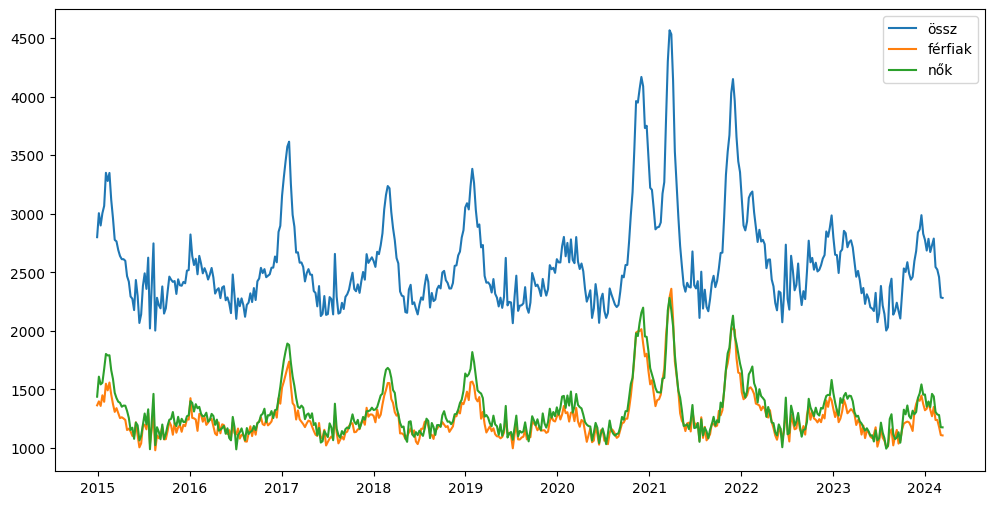

In [22]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='össz')
plt.plot(df['start'], df['man_total'], label='férfiak')
plt.plot(df['start'], df['woman_total'], label='nők')
plt.legend()

## Using Keras and 1D convolutional neural network

In [23]:
from numpy import zeros, mean
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

In [24]:
# split a univariate sequence into samples
def split_sequence(seq, n_steps):
	sequence = seq.to_numpy()
	n = sequence.shape[0]
	X = zeros((n - n_steps, n_steps))
	y = sequence[n_steps:]
	for i in range(n-n_steps):
		X[i] = sequence[i:i+n_steps]
	return X, y

In [25]:
# define input sequence
raw = df.loc[df['start'] <= '2024-01-01']
raw_seq = raw['all_total']
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [26]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# fit model
hist = model.fit(X, y, epochs=1000, verbose=0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

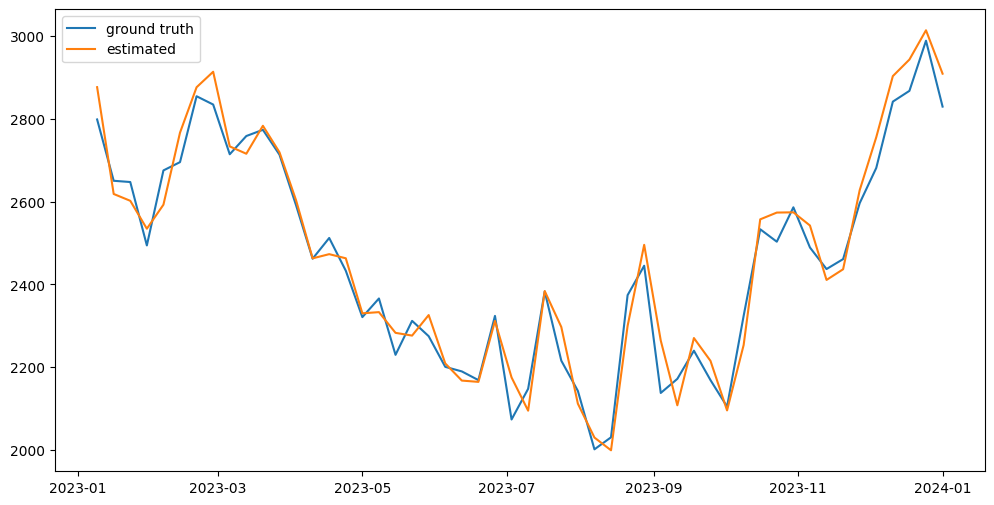

In [27]:
# predict values from model
y_pred = model.predict(X, verbose=0)
plt.figure(figsize=(12,6))
plt.plot(raw["start"][-52:], y[-53:-1], label='ground truth')   # TODO one week shift!
plt.plot(raw["start"][-52:], y_pred[-52:], label='estimated')
plt.legend()

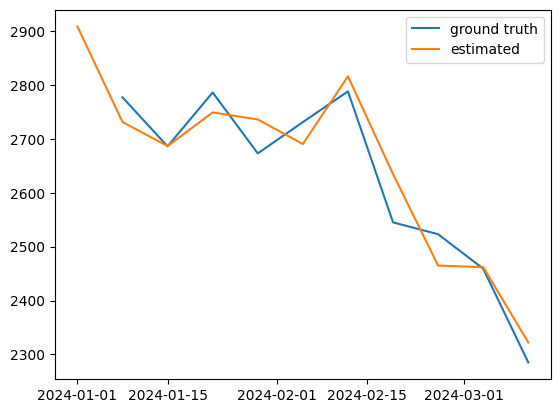

In [28]:
# make estimation for 2024 data
test = df.loc[df['start'] >= '2023-12-11']
test_seq = test['all_total']
X_test, y_test = split_sequence(test_seq, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred = model.predict(X_test, verbose=0)
plt.plot(test['start'][-y_test.shape[0]+1:], y_test[:-1], label='ground truth')
plt.plot(test['start'][-y_test.shape[0]:], y_test_pred, label='estimated')
plt.legend()

In [29]:
# mean prediction error
mfe_train = mean(y[:-1] - y_pred[1:])
print(f"Mean prediction error for train: {mfe_train:.1f}")
mfe_test = mean(y_test[:-1] - y_test_pred[1:])
print(f"Mean prediction error for  test: {mfe_test:.1f}")

Mean prediction error for train: -9.9
Mean prediction error for  test: -3.9


## Using XGBoost

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [4]:
# adatok betöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])
# feature creation
df['quarter'] = df['start'].dt.quarter
df['month'] = df['start'].dt.month
df['julian'] = pd.DatetimeIndex(df['start']).to_julian_date()

FEATURES = ['julian', 'year', 'quarter', 'month', 'week']
TARGET = 'all_total'

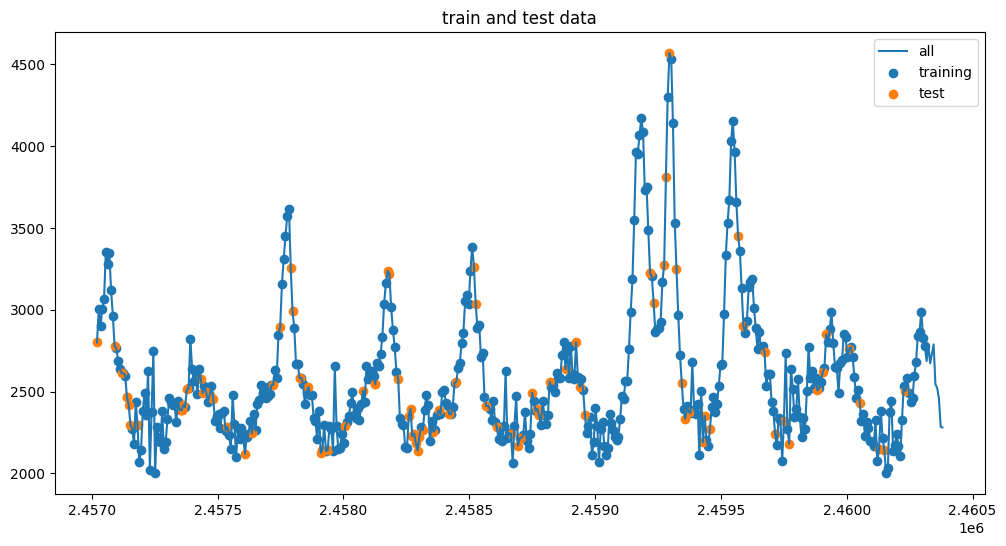

In [11]:
# split data into train and test set
raw = df.loc[df['start'] <= '2024-01-01']
raw_seq = raw['all_total']
X = raw[FEATURES].to_numpy()
y = raw_seq.to_numpy()
n = y.shape[0]
indx = np.random.randint(n, size=int(0.2*n))   # véletlen indexek teszt adatokhoz
X_test = X[indx]; y_test = y[indx]
mask = np.ones(n, dtype=bool)
mask[indx] = False
X_train = X[mask]; y_train = y[mask]
plt.figure(figsize=(12,6))
plt.plot(df['julian'], df['all_total'], label='all')
plt.scatter(X_train[:,0], y_train, label='training')
plt.scatter(X_test[:,0], y_test, label='test')
plt.legend()
_ = plt.title("train and test data")

In [76]:
sc = StandardScaler()
sc.fit(X)   # normalizálás paraméterei
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [45]:
# create model and fit
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=100,
                       objective= 'reg:squarederror', #'reg:linear',
                       max_depth=9,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2596.60870	validation_1-rmse:2563.01691
[100]	validation_0-rmse:991.38652	validation_1-rmse:975.30294
[200]	validation_0-rmse:407.61718	validation_1-rmse:399.74694
[300]	validation_0-rmse:190.04144	validation_1-rmse:199.27855
[400]	validation_0-rmse:104.62728	validation_1-rmse:143.15640
[500]	validation_0-rmse:68.10231	validation_1-rmse:130.71866
[600]	validation_0-rmse:51.37139	validation_1-rmse:130.40659
[627]	validation_0-rmse:48.47677	validation_1-rmse:131.06617


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

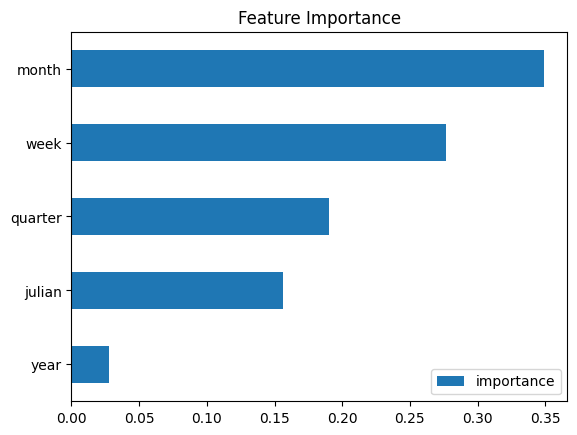

In [46]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=FEATURES,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [47]:
# estimate future data
raw = df.loc[df['start'] >= '2024-01-01']
raw_seq = raw['all_total']
X_new = raw[FEATURES].to_numpy()
y_new_pred = reg.predict(X_new)

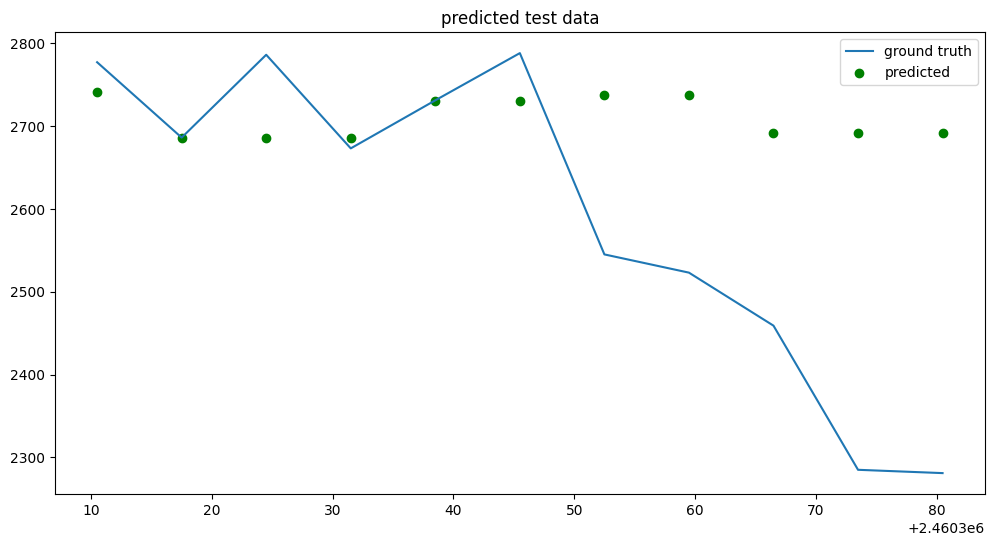

In [48]:
y_pred = reg.predict(X_test)
plt.figure(figsize=(12,6))
#plt.plot(X[:,0], y, label='ground true')
plt.plot(raw['julian'], raw['all_total'], label='ground truth')
#plt.scatter(X_test[:,0], y_pred[], c='red', label='predicted')
plt.scatter(X_new[:,0], y_new_pred, c='green', label='predicted')
plt.legend()
_ = plt.title("predicted test data")